# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. Den tar et sett med bilder, som skal klassifiseres, samt noen labels som forteller bildenes sanne binære verdi. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt. Først skal det nevrale nettverket trenes. I denne fasen skal parameterne assosiert med hver transformasjon av bildet finnes slik at avviket mellom den reelle klassifiseringen til bildet og modellen sin klassifisering blir minimert. Avviket beregnes ved hjelp av en kostfunksjon, som benytter seg av settet med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. Deretter skal et nytt sett med bilder gjennom en valideringsfase, der disse transformeres ved hjelp av parameterne som ble funnet i treningsfasen. Deretter kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

Denne rapporten består av kode, samt presentasjon av resultater fra to testproblemer:

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er dermed et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 2 og 7. 

Rapporten tar for seg testproblemene hver for seg. All kode for nettverket og algoritmen som brukes på begge problemene presenteres helt øverst i rapporten. Deretter følger det trening, validering og presentasjon av resultater fra henholdsvis problem 1 og problem 2. Det vil presenteres en tabelloversikt over suksessrater til modellene i begge oppgavene - en oversikt over andel bilder som ble klassifisert på korrekt måte. I tillegg skal to spesifikke eksempler fra trening i hver av oppgavene presenteres. Et av disse eksemplene viser et godt resultat, mens det andre eksempelet viser et svakt resultat. Kostfunksjonens konvergens blir plottet, sammen med treningsdataenes utgangsposisjoner og transformerte posisjoner. 


## Modell og algoritme

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spirals import *
from plotting import * 
from loader import *
import pickle

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return 1-(np.tanh(x))**2  

def eta(x):
    return 0.5*(1+sigma(x/2))

def eta_der(x):
    return 0.25*sigma_der(x/2)    

def adam_method(x, x_der, m_jn, v_jn, j):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def set_random_parameters(K, d):
    
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k, omega, my

def initialize(K,d,I):
    Y_Kk = np.zeros((K+1,d,I))
    b_k_dim = np.zeros((K,d,I))  #Kunne vi holdt oss med å lage én b_k? Nå virker det litt kaotisk 
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #For matrisemultiplikasjon
    P_Kk = np.zeros((K,d,I)) 
    return Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk

def stochastic_gradient_descent(Y_0, C, I_tot, chunk): 
    ''' Made to pick out pictures to test. Modifies the Adam Descent Algorithm. ''' 
    start = np.random.randint(I_tot-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] 
    C_chunk = C[start:start+chunk]
    return Y0_chunk, C_chunk 

def calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K):
    for i in range(K):
        b_k_dim[i,:,:] = b_k[i,:,:]    #Lager I kolonner med b_k[i], for at dimensjonen skal passe ved addisjon under
        Y_Kk[i+1] = Y_Kk[i] + h*sigma(W_k[i] @ Y_Kk[i] + b_k_dim[i]) 
    
    Z = eta(np.transpose(Y_Kk[-1]) @ omega + my)  
    return Y_Kk, b_k_dim, Z

def calculate_projection_derivatives(my, omega, Y_Kk, Z, c):
    ''' Calculates parts of gradient (5) and (6) '''
    YT_k = np.transpose(Y_Kk[-1])  #Kunne fjernet denne og satt den inn i lignene nedenfor kanskje?
   
    J_der_my = np.transpose(eta_der(YT_k @ omega + my)) @ (Z-c) 
    J_der_omega = Y_Kk[-1] @ ((Z-c) * eta_der(YT_k @ omega + my))
    return J_der_my, J_der_omega

def calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I):
    ''' Calculates P_(k-1) from (8) '''
    YT_k = np.transpose(Y_Kk[-1])   #Kunne fjernet denne og satt den inn i lignene nedenfor kanskje?
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my))
    P_Kk[-1] = P_k      

    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1] = P_Kk[i] + h*np.transpose(W_k[i-1]) @ (sigma_der(W_k[i-1] @ Y_Kk[i-1] +b_k_dim[i-1]) * P_Kk[i])
    
    for i in range(K):
        val = P_Kk[i] * sigma_der(W_k[i] @ Y_Kk[i] + b_k_dim[i])
        J_der_W[i] = h*(val @ np.transpose(Y_Kk[i]))
        J_der_b[i] = h*(val @ vec_I)
        
    return J_der_W, J_der_b

#Er det nødvendig å ta med alle konstanter i parameterlistene?
def algorithm(Y_0, c, K, d, iterations, h, I, chunk): 
    
    W_k, b_k, omega, my = set_random_parameters(K, d)
    
    j = 1
    J = np.zeros(iterations)
    
    stochastic_method = False
    if chunk < I: #Stocastic method
        I_tot = I  #new variable name
        I = chunk  #to get right dimensions below
        Y_0_tot = Y_0
        c_tot = c
        stochastic_method = True
    
    Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk = initialize(K, d, I)
    
    #Til Adam-metoden:
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    
    while j <= iterations:
        if stochastic_method:
            Y_0, c = stochastic_gradient_descent(Y_0_tot, c_tot, I_tot, chunk)
        
        Y_Kk[0] = Y_0
        Y_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K) #Makes new Y_Kk and b_k_dim
        
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2
        
        J_der_my, J_der_omega = calculate_projection_derivatives(my, omega, Y_Kk, Z, c) 
        
        J_der_W, J_der_b = calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I)
        
        my, m_j[0],v_j[0] = adam_method(my, J_der_my, m_j[0], v_j[0], j)
        omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1], j)
        b_k, m_j[2],v_j[2] = adam_method(b_k,J_der_b,m_j[2],v_j[2], j)
        W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3], j)
        
        j+= 1
    return my, omega, b_k, W_k, Y_Kk, J, Z, c 

#used to plot the results below
def forward_function(grid):
    ''' A function that takes one argument, an ?2-by-S? matrix of S datapoints, and
    returns a vector of S classification values.'''    
    b_k_dim = np.zeros((K,d,len(grid[0,:])))
    grid_Kk = np.zeros((K+1,d,len(grid[0,:])))
    grid_Kk[0] = grid
    grid_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, grid_Kk, b_k_dim, h, K)
    return Z

def last_function(grid):
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    Z = eta(np.transpose(grid) @ omega + my)
    return Z

def plot_cost_function_convergence(iterations, J):
    ''' Plots the convergence of the cost function as a function of the iteration index ''' 
    j_values = [i for i in range(1,iterations+1)]
    plt.figure()
    plt.plot(j_values, J)
    plt.xlabel("Iteration index j")
    plt.ylabel("Cost")
    plt.title("Convergence of cost function")
    plt.show()

def print_successrate(Z, c, tol=0.5): #All values under 0.5 goes to zero and all values above goes to 1
    correctly_classified = 0
    for i in range(len(Z)):
        if abs(Z[i]-c[i]) <= tol:
            correctly_classified+=1
    print("Ratio of correctly classified points:", correctly_classified/len(c),"(with tolerated difference between classification point and label:",str(tol)+")")

def write_to_file(my, omega, b_k, W_k, filename):
    U = [my, omega, b_k, W_k]
    with open(filename, "wb") as f:
        pickle.dump(U, f)

def test_parameters(Y_0, h, K, d, I, filename):
    with open(filename, "rb") as f:
        U = pickle.load(f)
    my, omega, b_k, W_k = U[0], U[1], U[2], U[3]
    Y_Kk = np.zeros((K+1,d,I))
    b_k_dim = np.zeros((K,d,I))
    Y_Kk[0] = Y_0
    Y_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K)
    return Y_Kk, Z

def show_image(Y_k, n):
    for i in range(n):
        image = Y_k[:,i].reshape((28,28))
        plt.imshow(image)
        plt.show()


ModuleNotFoundError: ignored

## Testproblem 1 - punkter i planet


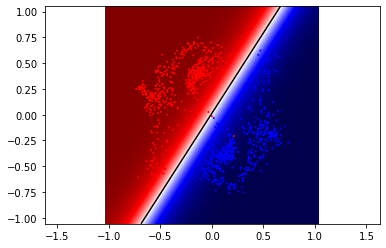

In [0]:
d = 2  
h = 0.1

print("Training session:")
K = 15    #K har veldig mye å si på hvor fort J konvergerer
I = 1000   
iterations = 10000  
chunk = I

Y_0, c = get_data_spiral_2d(I)
c = c[:,0]

my, omega, b_k, W_k, Y_Kk, J, Z, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k, W_k, "parameters_points.txt")

print_successrate(Z,c, tol=0.05)
plot_cost_function_convergence(iterations, J)
print("Last item of J function", J[-1])

print("Testing parameters:")
#Kan jeg endre noen konstanter her - kan kanskje endre I, men K,d,h må være samme

Y_0, c_test = get_data_spiral_2d(I)
Y_Kk_test, Z_test = test_parameters(Y_0, h, K, d, I, "parameters_points.txt")
print_successrate(Z_test,c_test, tol=0.05)

In [0]:
print("Plotting test-results")
plot_model(forward_function,Y_Kk_test[0,:,:],c_test,100)
plot_progression(Y_Kk_test, c_test)
plot_separation(last_function,Y_Kk_test[-1,:,:],c_test,100)

### Presentasjon av resultater: 


### Suksessrater: 

Modellen har blitt trent og testet en rekke flere ganger, på samme måte som eksempelet over. Resultatene er presentert i tabellen nedenfor. 

Trente modellen med 40000 iterasjoner. 1000 bilder. K = 20 lag, og hhv h = 0.1, 0.3, 0.5, 0.7 og 0.9.
Deretter kjørte testing på denne dataen med 10, 15 og 30 lag i nettverket. Det er dette man ser i tabellen nedenfor. 

| tol = 0.05 | K = 5 | K = 7 | K = 10 | K = 15 | K = 17 | K = 20 |
|------------|-------|:-----:|--------|--------|--------|--------|
| h = 0.1    | 0.069 | 0.437 | 0.997  | 0.997  | 0.996  | 0.999  |
| h = 0.3    | 0.153 | 0.888 | 0.998  | 0.996  | 0.997  | 0.234  |
| h = 0.5    | 0.930 | 0.565 | 0.010  | 0.364  | 0.997  | 0.217  |
| h = 0.7    | 0.077 | 0.576 | 0.998  | 0.997  | 0.0    | 0.985  |
| h = 0.9    | 0.914 | 0.344 | 0.848  | 0.0    | 0.678  | 0.995  |


Hvis man ser på J-funksjonen til f.eks h0.9,K17 ser man at det er veldig flaks at den resultatet blir såpass bra etter 40000 iterasjoner, for den konvergerer ikke mot en lav verdi (den oscillerer helt vilt). Dermed kan f.eks denne være interessant å plotte. Dette er nok tilfellet på mange flere av disse derimot (blant de større h-verdiene!). h0.7,K17 hadde nok ikke like flaks. 

Tester heller med K = 5, for å se hvor mye de siste 10-15 lagene har å si!

Toleransen ble satt til 0.05 under klassifiseringen i denne oppgaven, for å se hvor mye modellen kunne få rett når man er mye sikrere enn 50 %. Ved tol 0.5 ble resultatene ...

Tror det er noe avvik i treninga på noen av disse som er veldig lave. Test gjerne dere hvis dere er keen



### Konklusjon

Basert på suksessratene er det åpenbart at det er bedre med flere lag, men man taper altså ikke så mye ved å kutte noen lag. Det ser ut til å gjennomgående fungere bedre når h er mindre, slik at steglengden ikke blir så "voldsom" og kostfunksjonen konvergerer mot en lav verdi (slik den ikke gjør for flere av de større h-ene)

## Testproblem 2 - håndskrevne siffer

In [2]:
d = 784     #28x28
h = 0.1

print("Training session: ")
K = 10            #ser ut som konvergensen nesten er helt uavh. av K. K=3 og K=18 gir omtrent det samme
chunk = 256      #kurven blir mye glattere med stor chunk
iterations = 350  #Konvergerer ish etter 400 iterasjoner

#Y_0, c = get_dataset()  #784x1233
#c = c[:,0]
#Y_0 = Y_0/255   #For å få mye kjappere konvergens, men kanskje noe feil

#my, omega, b_k, W_k, Y_Kk, J, Z, c  = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
#write_to_file(my, omega, b_k, W_k, "parameters_images.txt")

#print_successrate(Z, c, tol=0.05)
#plot_cost_function_convergence(iterations, J)

Training session: 
